# Experiments with QUIMB
## Imports

In [1]:
import quimb as qu
from quimb import tensor as qtn
from utils import *

/home/ubuntu/data/ttn4hep/TTN/utils.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
import torch
from torchinfo import summary
import torchvision as tv
import numpy as np
import scipy as sp
#import cupy as cp
import pandas as pd
import string
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
from datetime import datetime

# Try a TTN on MNIST

## Preprocess

In [4]:
h = 8
BATCH_SIZE = 64
selected_labels = [0, 1]
root_dir = '../'

mnist_test  = tv.datasets.MNIST(root_dir + 'data', download=True, train=False, transform=get_ttn_transform(h))
mnist_train = tv.datasets.MNIST(root_dir + 'data', download=True, train=True, transform=get_ttn_transform(h))
mnist_train_visual = tv.datasets.MNIST(root_dir + 'data', download=True, train=True, transform=get_ttn_transform_visual(h))

balanced_train, balanced_test = balance(selected_labels, mnist_train, mnist_test)

test_dl = torch.utils.data.DataLoader(balanced_test, batch_size=BATCH_SIZE)
train_dl = torch.utils.data.DataLoader(balanced_train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=14)
train_visual = torch.utils.data.DataLoader(mnist_train_visual, batch_size=BATCH_SIZE)

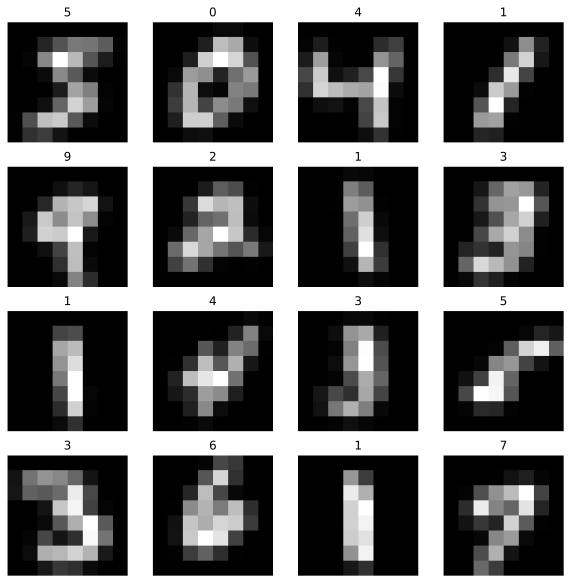

In [5]:
images, labels = next(iter(train_visual))
images = images[:16,0]

fig, axs = plt.subplots(4, 4, figsize=(10,10))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f'{labels[i]}')
    ax.set_axis_off()

## Define model

preparing dataset:   0%|          | 0/186 [00:00<?, ?it/s]

ttn init:   0%|          | 0/992 [00:00<?, ?it/s]

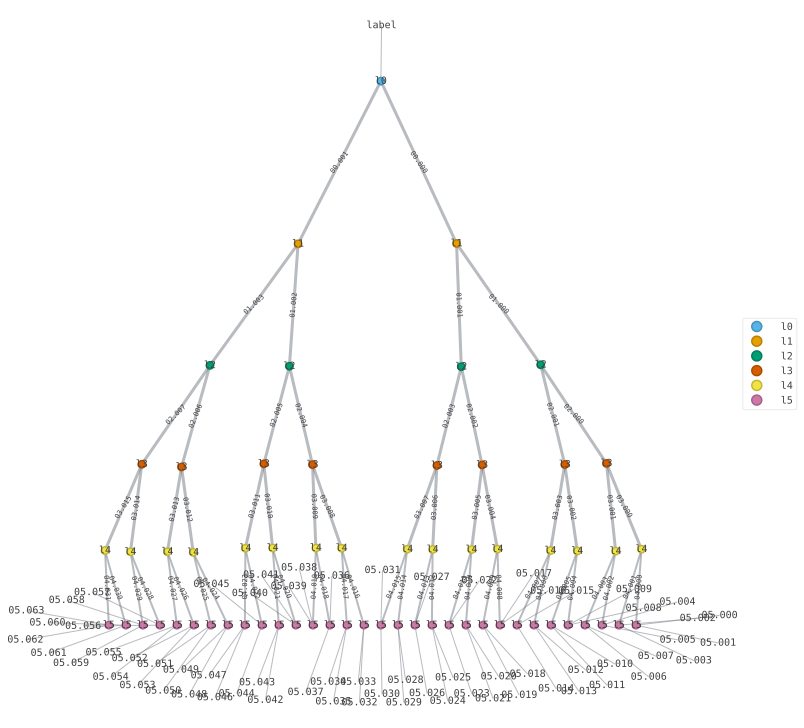

Layer (type:depth-idx)                   Output Shape              Param #
TNModel                                  [64, 2]                   9,856
Total params: 9,856
Trainable params: 9,856
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.13
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.13

In [6]:
MyTTN = TTN(h**2, n_labels=2, bond_dim=8, device='cuda')
MyTTN.initialize(train_dl=train_dl)
model = TNModel(MyTTN)
model.draw()
summary(model, input_size=next(iter(train_dl))[0].squeeze().shape, dtypes=[torch.complex128])

In [7]:
def check_correct_init(model: TNModel):
    # gives true if correctly initialized and also the number of errors
    result_list = []
    for layer in range(model.myttn.n_layers-1,0,-1):
        layer_tensors = model.myttn.select_tensors(f'l{layer}')
        for id, tensor in enumerate(layer_tensors):
            contr = tensor.contract(tensor.H, output_inds=[f'{layer-1:02}.{id:003}'])
            result = torch.allclose(contr.data, torch.ones(contr.shape[-1], dtype=torch.complex128, device='cuda'))
            if not result:
                print(f'Layer {layer}, tensor {id} is not initialized correctly')
            result_list.append(not result)
    
    n_errors = torch.tensor(result_list, dtype=torch.bool).sum().item()
    return n_errors == 0, n_errors

check_correct_init(model)

(True, 0)

In [8]:
# outdated (does not take into account the min(2^l, chi) rule)
def th_nparams(ttn):
    # return the expected number of parameters in the TN
    # based on TN structure
    return ttn.n_features*2*ttn.bond_dim+ttn.bond_dim**3*2*(2**(ttn.n_layers-2)-1)+ttn.bond_dim**2*ttn.n_labels

th_nparams(MyTTN)

16512

## Training with pytorch

In [12]:

def train_one_epoch(model, device, train_dl, loss_fn, optimizer):
    running_loss = 0.
    last_loss = 0.
    last_batch = 0
    loss_history = []

    #model.to(device)

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    pbar = tqdm(enumerate(train_dl), total=len(train_dl),position=0)
    for i, data in enumerate(train_dl):

        # Every data instance is an input + label pair
        inputs, labels = data
        inputs, labels = inputs.squeeze().to(device, dtype=torch.complex128, non_blocking=True), labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)
        probs = torch.real(torch.pow(outputs, 2))

        probs = probs / torch.sum(probs)

        # Compute the loss and its gradients
        loss = loss_fn(labels, probs)
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        loss_history.append(loss.item())
        if i % 10 == 9:
            last_batch = i+1
            last_loss = running_loss / 10 # loss per batches
            running_loss = 0.
        pbar.update()
        pbar.set_postfix({'current loss': loss.item(), f'batches {last_batch-10}-{last_batch} loss': last_loss})
    pbar.set_postfix({'current loss': loss.item(), f'batches {last_batch-10}-{last_batch} loss': last_loss, 'epoch mean loss': np.array(loss_history).mean()}) # not correct as the last batch is averaged on less samples
    pbar.close()
    return loss_history


In [13]:
def loss(labels, output):
    #labels[labels!=1] = 0
    return torch.mean(torch.sum((output - torch.nn.functional.one_hot(labels))**2, 1))/2

In [14]:
LR = 1e-1
device = 'cuda'
model.train()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, .5, 8)
model.to(device)

In [21]:
EPOCHS = 10
tot_loss_history = []
now = datetime.now()
for epoch in trange(EPOCHS):
    loss_history = train_one_epoch(model, device, train_dl, loss, optimizer)
    tot_loss_history += loss_history
    scheduler.step()
    
loss_history = np.array(tot_loss_history)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

In [26]:
torch.save(model.state_dict, f'models/trainedmodel_{now.strftime("%Y%m%d-%H%M%S")}.dict')
np.save(f'models/loss_history_{now.strftime("%Y%m%d-%H%M%S")}.npy', loss_history)

0.47744863172126967


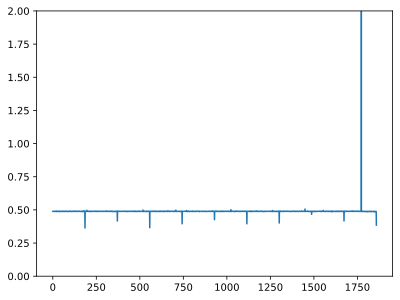

In [25]:
plt.plot(range(len(loss_history)), loss_history)
plt.ylim(0, 2)
print(np.mean(loss_history[-10:]))

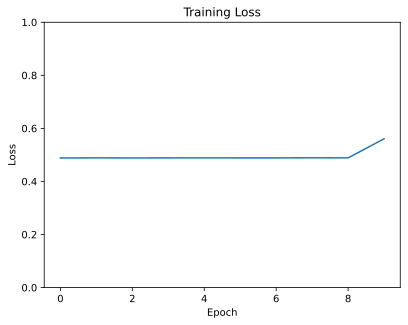

In [23]:
plt.plot([loss_history[i*len(train_dl):((i+1)*len(train_dl) if i<EPOCHS-1 else -1)].mean() for i in range(EPOCHS)])
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [24]:
def accuracy(model, device, train_dl, test_dl):
    correct = 0
    total = 0

    model.eval()
    model.to(device)

    with torch.no_grad():
        for data in tqdm(test_dl, total=len(test_dl), position=0, desc='test'):
            images, labels = data
            images, labels = images.to(device, dtype=torch.complex128).squeeze(), labels.to(device)
            outputs = model(images)
            probs = torch.real(torch.pow(outputs, 2))
            probs = probs / torch.sum(probs)
            _, predicted = torch.max(probs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_accuracy = correct / total

        correct = 0
        total = 0

        for data in tqdm(train_dl, total=len(train_dl), position=0, desc='train'):
            images, labels = data
            images, labels = images.to(device, dtype=torch.complex128).squeeze(), labels.to(device)
            outputs = model(images)
            probs = torch.real(torch.pow(outputs, 2))
            probs = probs / torch.sum(probs)
            _, predicted = torch.max(probs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_accuracy = correct / total

    return train_accuracy, test_accuracy


accuracy(model, device, train_dl, test_dl)

test:   0%|          | 0/31 [00:00<?, ?it/s]

train:   0%|          | 0/186 [00:00<?, ?it/s]

(0.8301536383589397, 0.6331632653061224)

# Deprecated code

## Training with quimb

not possible as the quimb optimization suppose the measurement of an hamiltonian and the minimization of the energy, not suitable if data are supplied during the training process. We would have to think about an hamiltonian whose ground state is the state we want.

In [17]:
tnopt = qtn.TNOptimizer(
    # the tensor network we want to optimize
    MyTTN.net,
    # the functions specfying the loss and normalization
    loss_fn=loss_fn,
    #norm_fn=norm_fn,
    # we specify constants so that the arguments can be converted
    # to the  desired autodiff backend automatically
    #loss_constants={"ham": ham},
    # the underlying algorithm to use for the optimization
    # 'l-bfgs-b' is the default and often good for fast initial progress
    optimizer="adam",
    autodiff_backend="torch",
)
tnopt

<TNOptimizer(d=34048, backend=torch)>

In [18]:
tnopt.optimize(100)

  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: CrossEntropyLoss.forward() missing 1 required positional argument: 'target'

## Try TTN on Titanic dataset

In [4]:
from torch.utils.data import Dataset, DataLoader

dataset = pd.read_csv('../data/titanic.csv')
data_trimmed = dataset.drop(['Name', 'Ticket'], axis=1).copy()

In [5]:
def convert_single_cab(cab):
    result = 0
    num_pow = 0
    alpha_pow = 3
    if pd.isna(cab): return 0
    else:
        for char in cab[::-1]:
            if char.isdigit():
                result += 10**num_pow*int(char)
                num_pow += 1
            elif char.isalpha():
                result += 10**alpha_pow*(string.ascii_uppercase.index(char)+1)
            elif char.isspace():
                continue
            else:
                print('Error converting cabin number')
                return None
        return result
    
def convert_cabs(cabs):
    if pd.isna(cabs): return 0
    else: return np.mean(list(map(convert_single_cab, cabs.split())))

miao = data_trimmed['Cabin'].apply(convert_cabs)

In [6]:
class TitanicDataset(Dataset):
    def __init__(self, filepath, transform=None):
        self.data = pd.read_csv(filepath)
    
        # convert to numerical
        self.data['Cabin_num'] = self.data['Cabin'].apply(convert_cabs)
        self.data['Sex_num'] = pd.Categorical(self.data['Sex']).codes
        self.data['Embarked_num'] = pd.Categorical(self.data['Embarked']).codes

        #trim useless columns
        self.data = self.data.drop(['PassengerId', 'Name', 'Sex', 'Cabin', 'Embarked', 'Ticket'], axis=1).dropna(axis=0).copy()

        self.transform = transform
        
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        label = np.array(self.data.iloc[idx, 0])
        data = np.array(self.data.iloc[idx, 1:])

        if self.transform:
            data = self.transform(data)

        return data, label

In [8]:

titanic_dataset = TitanicDataset('../data/titanic.csv', transform=tv.transforms.Lambda(quantize))

titanic_dl = DataLoader(titanic_dataset, batch_size=64)

In [9]:
datum = next(iter(titanic_dl))[0]
datum.shape

torch.Size([64, 8, 2])

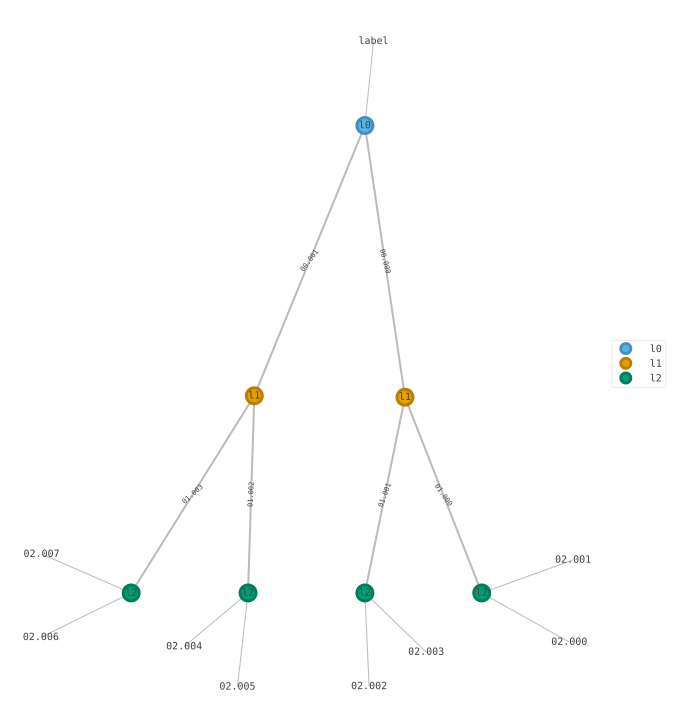

In [10]:
titanic_TTN = TTN(8)
titanic_model = TNModel(titanic_TTN)
titanic_model.draw()

In [11]:
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(titanic_model.parameters())

In [14]:
titanic_model.train()
train_one_epoch(titanic_model, titanic_dl)

  0%|          | 0/12 [00:00<?, ?it/s]

[-98.08844112977505, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

## Code examples from quimb official site

In [111]:
data = qu.bell_state('psi-').reshape(2, 2)
inds = ('k0', 'k1')
tags = ('KET',)

ket = qtn.Tensor(data=data, inds=inds, tags=tags)
ket

Tensor(shape=(2, 2), inds=('k0', 'k1'), tags=oset(['KET']))

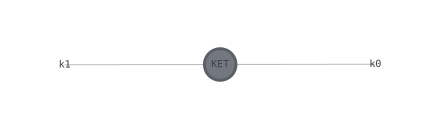

In [112]:
ket.draw()

In [113]:
X = qtn.Tensor(qu.pauli('X'), inds=('k0', 'b0'), tags=['PAULI', 'X', '0'])
Y = qtn.Tensor(qu.pauli('Y'), inds=('k1', 'b1'), tags=['PAULI', 'Y', '1'])
bra = qtn.Tensor(qu.rand_ket(4).reshape(2, 2), inds=('b0', 'b1'), tags=['BRA'])
X

Tensor(shape=(2, 2), inds=('k0', 'b0'), tags=oset(['PAULI', 'X', '0']))

In [114]:
TN = ket.H & X & Y & bra
TN

TensorNetwork(tensors=4, indices=4)

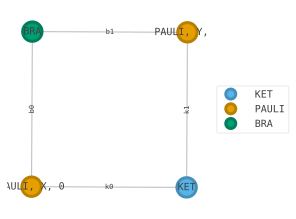

In [115]:
TN.draw(color=['KET', 'PAULI', 'BRA'], figsize=(4, 4), show_inds='all')

In [116]:
TN ^ ...

(-0.09308328668288901+0.1331677810864347j)

## Let's try to build a TTN

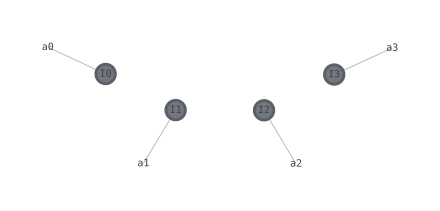

In [139]:
# generating a random MPS

ket_mps = qtn.MPS_rand_state(4, 1, site_ind_id='a{}')
ket_mps.draw()

In [140]:
ket_mps.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float32, requires_grad=True))
ket_mps

MatrixProductState(tensors=4, indices=7, L=4, max_bond=2)

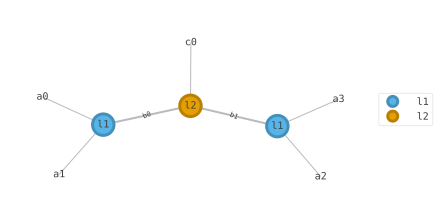

In [141]:
T1 = qtn.rand_tensor((2,2,4), inds=('a0', 'a1', 'b0'), tags=['l1'])
T2 = qtn.rand_tensor((2,2,4), inds=('a2', 'a3', 'b1'), tags=['l1'])
T3 = qtn.rand_tensor((4, 4, 2), inds=('b0', 'b1', 'c0'), tags=['l2'])

TN = T1 & T2 & T3
TN.draw(color=['l1', 'l2'], show_inds='all')
TN.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float32, requires_grad=True))

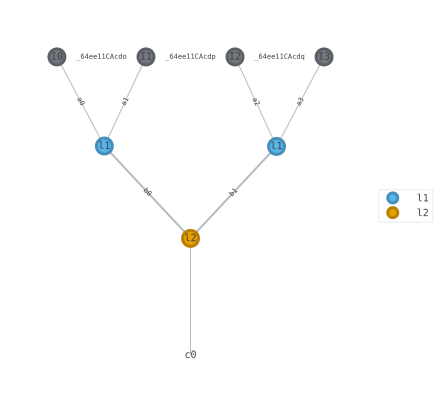

In [142]:
(TN & ket_mps).draw(color=['l1', 'l2'], show_inds='all', fix={'I{}'.format(i): (i, 5) for i in range(4)} )

In [143]:
contr = (TN & ket_mps).contract(..., backend='torch')

In [144]:
contr.data

tensor([-10.9518,   1.9017], grad_fn=<ViewBackward0>)